<a href="https://colab.research.google.com/github/veersubandh/DS1002-S24/blob/main/Assignments/12_CAPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Capital Asset Pricing Model (CAPM)

### Assignment due Monday 22 April at noon

---

### Objectives

This assignment is primarily meant to refresh your numpy and pandas skills.  
Technical objectives are discussed below.  

- All the usual rules apply:  you may work together (groups of at most 3), make sure all names are easy to find at the top of the submission, submit the link to your working colab notebook


### Background

In finance, CAPM is a single-factor regression model used for analyzing (and predicting) excess stock returns. There are better, more accurate models, but it has its uses. For example, the *market beta* is a useful output which has something to do with the risk of particular investments.

1.  Read [this brief synopsis](https://en.wikipedia.org/wiki/Capital_asset_pricing_model) of CAPM.


Don't worry if you don't understand all the terminology.
Look for a moment at the main formula (in the "Formula" section).  For us that formula will look like this:

\begin{aligned}
E(R_A) = R_f + \beta_A (E(R_{SP}) - R_f)
\end{aligned}

Some notes on the symbols in this formula:
- The formula is used to estimate $E(R_A)$.  The $E$ here stands for the expected value, and $R_A$ is the rate of return of the investment $A$.
- To use this formula, you therefore need to know the values of the other variables.
- The variable $R_f$ is the "risk-free rate," which is the amount of return you can get on an investment that has zero risk, like say a bank account.
This quantity changes over time but for our purposes we can treat it as a constant.  It is hard-coded into the code below.  Make sure you see where this variable occurs in the formula above.
- In this assignment the variable $R_{SP}$ is a measure of the rate of return of the overall market.  (The $E$ on the right side also means expected value.)
- The variable $\beta_A$ measures something about the relative risk of the investment A, relative to the overall market.  The technical objective of this assignment will be to compute $\beta_A$ below, and then to examine how sensitive it is to the specific data.
- The value you get for $\beta_A$ will be a number.  If it is greater than 1, it means (*very roughly*) that the investment A is more volatile than the overall market.  If it is less than 1, it means that the investment is less volatile than the overall market.  But **do not take this too seriously!** In particular see all the caveats at the wikipedia page.
- The A investment in our example is an individual stock (Apple).



2.  Load the packages and data.  (Note that the following code chunk also hard-codes the constant $R_f$.)  
The data lives in the file `capm_market_data` in the `data` folder on the `GitHub` site.

Assignment by Anaya Nath and Veer Subandh

In [ ]:
# load numpy and pandas packages
import numpy as np
import pandas as pd

# get data
url= 'https://raw.githubusercontent.com/aaron-abrams-uva/DS1002-S24/main/data/capm_market_data.csv'
capm_data=pd.read_csv(url)
print(capm_data)
# risk-free Treasury rate
R_f = 0.0175 / 252

           date  spy_adj_close  aapl_adj_close
0    2020-01-02     321.555786      298.829956
1    2020-01-03     319.120911      295.924713
2    2020-01-06     320.338379      298.282715
3    2020-01-07     319.437653      296.879883
4    2020-01-08     321.140106      301.655548
..          ...            ...             ...
130  2020-07-09     314.380005      383.010010
131  2020-07-10     317.589996      383.679993
132  2020-07-13     314.839996      381.910004
133  2020-07-14     318.920013      388.230011
134  2020-07-15     321.850006      390.899994

[135 rows x 3 columns]


3.  Look at some records.  
SPY is something that mirrors the S&P 500 ("the market").  
AAPL is the code for Apple stock.  
The values are closing prices, adjusted for splits and dividends.

In [ ]:
# using .head(), display first few records for SPY and AAPL
spy_records = capm_data.head().spy_adj_close
aapl_records = capm_data.head().aapl_adj_close

print("First few records for SPY:")
print(spy_records.head())

print("\nFirst few records for AAPL:")
print(aapl_records.head())


First few records for SPY:
0    321.555786
1    319.120911
2    320.338379
3    319.437653
4    321.140106
Name: spy_adj_close, dtype: float64

First few records for AAPL:
0    298.829956
1    295.924713
2    298.282715
3    296.879883
4    301.655548
Name: aapl_adj_close, dtype: float64


4.  Drop the date column

In [ ]:
# Drop the 'date' column from the DataFrame
capm_new=capm_data.drop(columns=['date'])

# Print only the 'spy_adj_close' and 'aapl_adj_close' values
print("values for new capm without dates:")
print(capm_new.values)


values for new capm without dates:
[[321.55578613 298.82995605]
 [319.12091064 295.92471313]
 [320.33837891 298.28271484]
 [319.43765259 296.87988281]
 [321.1401062  301.6555481 ]
 [323.31762695 308.06298828]
 [322.38720703 308.75939941]
 [324.60440063 315.35586548]
 [324.10949707 311.09753418]
 [324.84191895 309.76431274]
 [327.5440979  313.64456177]
 [328.56359863 317.11694336]
 [327.92022705 314.96786499]
 [327.95980835 316.09216309]
 [328.3359375  317.6144104 ]
 [325.41601562 316.69903564]
 [320.19979858 307.38641357]
 [323.5552063  316.08218384]
 [323.28793335 322.69851685]
 [324.33712769 322.230896  ]
 [318.44784546 307.94360352]
 [320.81344604 307.09790039]
 [325.70306396 317.23629761]
 [329.46429443 319.82318115]
 [330.57287598 323.56411743]
 [328.81103516 319.16601562]
 [331.26571655 320.68191528]
 [331.83981323 318.74713135]
 [333.9777832  326.31668091]
 [333.62142944 323.99295044]
 [334.15594482 324.07275391]
 [333.2947998  318.13879395]
 [334.88839722 322.74633789]
 [333.51

5.  Compute daily returns (percentage changes in price) for both SPY and AAPL.
(Be sure to drop the first row of NaN.)  
Hint: pandas has functions to easily do this.  
Print the first 5 rows of returns.


In [ ]:
# Calculating the daily returns for SPY and AAPL using the .pct_change() function
capm_data['spy_returns'] = capm_data['spy_adj_close'].pct_change()
capm_data['aapl_returns'] = capm_data['aapl_adj_close'].pct_change()

# Dropping the first row containing NaN values
capm_data = capm_data.dropna()

# Printing the first 5 rows of returns
print("First 5 rows of percentage changes in price for SPY:")
print(capm_data['spy_returns'].head())

print("\nFirst 5 rows of percentage changes in price for AAPL:")
print(capm_data['aapl_returns'].head())

First 5 rows of percentage changes in price for SPY:
1   -0.007572
2    0.003815
3   -0.002812
4    0.005330
5    0.006781
Name: spy_returns, dtype: float64

First 5 rows of percentage changes in price for AAPL:
1   -0.009722
2    0.007968
3   -0.004703
4    0.016086
5    0.021241
Name: aapl_returns, dtype: float64


6.  Save the SPY and AAPL returns into separate numpy arrays.  
Print the first five values from each of the two arrays.


In [ ]:
# Saving SPY and AAPL returns into separate numpy arrays
spy_returns_array = capm_data['spy_returns'].values
aapl_returns_array = capm_data['aapl_returns'].values

# Printing the first five values from each array
print("First five values of SPY returns:")
print(spy_returns_array[:5])

print("\nFirst five values of AAPL returns:")
print(aapl_returns_array[:5])


First five values of SPY returns:
[-0.00757217  0.00381507 -0.0028118   0.00532953  0.00678059]

First five values of AAPL returns:
[-0.00972206  0.00796825 -0.00470303  0.01608619  0.02124092]


7.  Make arrays (one for SPY, one for AAPL) containing the *excess* returns by subtracting the constant $R_f$ from the returns.  
(Recall that $R_f$ is the "risk-free rate" meaning essentially that you could earn this much in interest if you didn't invest in anything.)  
Print the LAST five excess returns from both SPY and AAPL numpy arrays.

In [ ]:
# Defining the risk-free rate (R_f)
R_f = 0.0175 / 252  # Daily risk-free rate

# Computing excess returns for SPY and AAPL
spy_excess_returns = capm_data['spy_returns'] - R_f
aapl_excess_returns = capm_data['aapl_returns'] - R_f

#Printing the last five excess returns for SPY and AAPL
print("Last five excess returns for SPY:")
print(spy_excess_returns.tail())

print("Last five excess returns for AAPL:")
print(aapl_excess_returns.tail())

Last five excess returns for SPY:
130   -0.005762
131    0.010141
132   -0.008728
133    0.012890
134    0.009118
Name: spy_returns, dtype: float64
Last five excess returns for AAPL:
130    0.004231
131    0.001680
132   -0.004683
133    0.016479
134    0.006808
Name: aapl_returns, dtype: float64


8. Make a scatterplot with SPY excess returns on the $x$-axis and AAPL excess returns on the $y$-axis.  
If you need it, here is the [Matplotlib documentation]( https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html).

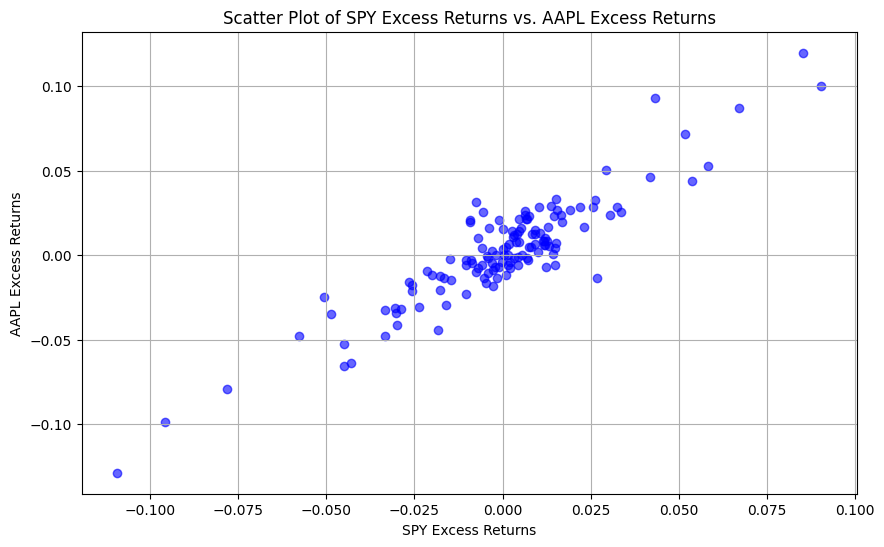

In [ ]:
import matplotlib.pyplot as plt

# Creating a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(spy_excess_returns, aapl_excess_returns, alpha=0.6, color='blue')

# Adding labels and a title
plt.title('Scatter Plot of SPY Excess Returns vs. AAPL Excess Returns')
plt.xlabel('SPY Excess Returns')
plt.ylabel('AAPL Excess Returns')

# Displaying the plot
plt.grid(True)
plt.show()


The value of $\beta_A$ is computed from the arrays you built in problem 7, via a formula that uses some statistical functions called the "variance" and the "covariance."

Any individual 1-d array of numbers has a variance, which you can compute using `numpy`'s function `var()` (documented [here](https://numpy.org/doc/stable/reference/generated/numpy.var.html)).  This is a number.

If you have two 1-d arrays of the same length, they collectively have something called a covariance which `numpy` also can compute using `cov()` (documented [here](https://numpy.org/doc/stable/reference/generated/numpy.cov.html)).

The covariance is also a number, but look at what happens when you send two 1-d arrays to `cov()`: it returns a $2\times 2$ matrix.  (Try it!)  The covariance we are looking for is the number that lives in both the top right and the bottom left of this matrix.  (Those two numbers should be the same.)  The top left and bottom right entries of the covariance matrix also have meaning, but we don't need them.



9. Use `numpy` functions as described above to compute the estimate of $\beta_A$, using the following formula:  
\begin{aligned} \beta_A= \frac{ \text{cov}(A,SP) }{ \text{var}(SP) } \end{aligned}
In our context, A will be the 1-d array you made in problem 7 for AAPL, and SP will be the 1-d array you made for SPY.

In [ ]:
# Computing the covariance between AAPL and SPY excess returns using the .cov() function
covariance_aapl_spy = np.cov(aapl_excess_returns, spy_excess_returns)[0, 1]

# Computing the variance of SPY excess returns using the .var() function
variance_spy = np.var(spy_excess_returns)

# Computing beta for AAPL
beta_aapl = covariance_aapl_spy / variance_spy

print("Beta for AAPL:", beta_aapl)

Beta for AAPL: 1.0956172644197222


You should have found that the beta estimate is greater than one.  
This means that the volatility of AAPL stock, given the data, and according to this particular (flawed) model,
is higher than the volatility of the S&P 500.

Bonus:  Is this something you can see on the plot you made?



Yes this is. This can be infered from a line of best fit. By sketching a rough line of best fit on ipad notes, we found that most of the data points for the AAPL stock are above this line of best fit. This supports the argument AAPL tends to have higher returns than the S&P 500 when the market as a whole has positive returns, indicating higher volatility for AAPL compared to the S&P 500 in the market.

Finally, let's look at how sensitive the beta is to each data point.   
We want to drop each data point (one at a time), compute \\(\hat\beta_i\\) using our formula from above, and save each measurement.

This is called *jackknifing*.



10. Write a function called `beta_sensitivity()` with these specs:

- take numpy arrays `x` and `y` as inputs
- outputs a list of tuples, so that each tuple contains (observation row dropped, beta estimate)

Hint: **np.delete(x, i).reshape(-1,1)** will delete observation i from array x, and make it a column vector

In [ ]:
def beta_sensitivity(x, y):
    """
    Computing the sensitivity of beta to each data point by dropping each data point one at a time
    computing the beta estimate, and record each measurement.

    inputs:
    x (numpy array): Array representing the independent variable.
    y (numpy array): Array representing the dependent variable.

    Returns:
    list of tuples: Each tuple contains observation row dropped and a beta estimate).
    """
    sensitivity_list = []
    n = len(x)  # Number of data points

    for f in range(n):
        # Drop the f-th observation from x and y where f is the index of the operation being dropped one at a time from the input arrays
        x_without_f = np.delete(x, f)
        y_without_f = np.delete(y, f)

        # Compute the covariance between y and x_without_i and the variance of x_without_i
        covariance = np.cov([y_without_f, x_without_f], bias=True)[0, 1]
        variance = np.var(x_without_f)

        # Compute beta estimate for the i-th observation
        beta_estimate = covariance / variance

        # Append tuple (observation row dropped, beta estimate) to sensitivity_list
        sensitivity_list.append((f, beta_estimate))

    return sensitivity_list

sensitivity_results = beta_sensitivity(aapl_excess_returns, spy_excess_returns)
print(sensitivity_results)



[(0, 0.7721773010753973), (1, 0.7720737177862436), (2, 0.7721688371711777), (3, 0.7725862155232633), (4, 0.7731370481936639), (5, 0.772037681208339), (6, 0.7731440996535965), (7, 0.7732618263072744), (8, 0.7723960344961741), (9, 0.772027662487823), (10, 0.7722827587275812), (11, 0.7723703481067808), (12, 0.7720515969765621), (13, 0.7720601342263419), (14, 0.7718438629457381), (15, 0.7739647516663848), (16, 0.7738792011887203), (17, 0.7741036795626609), (18, 0.7722145490765443), (19, 0.7781304594399177), (20, 0.7724684262893542), (21, 0.7739721461007283), (22, 0.7717653266129338), (23, 0.7723156462757408), (24, 0.7728316060523144), (25, 0.7719571054176115), (26, 0.772537583159881), (27, 0.7736350009000669), (28, 0.7724633526584982), (29, 0.7720928638564056), (30, 0.7740318165377109), (31, 0.7724621159036981), (32, 0.7725428015218428), (33, 0.7736454702283828), (34, 0.7739180342383641), (35, 0.7713568766841823), (36, 0.7734319516649479), (37, 0.775669778650454), (38, 0.7719944735460922),

11. Call `beta_sensitivity()` on the arrays A and SP from earlier and print the first ten tuples of output.

In [ ]:
# Calling beta_sensitivity()function on the arrays
sensitivity_results = beta_sensitivity(aapl_excess_returns, spy_excess_returns)

# Printing the first ten tuples of output
print("First ten tuples of output:")
for i in range(10):
  #where i represents the index of each tuple in the sensitivity_results list
    print(sensitivity_results[i])

First ten tuples of output:
(0, 0.7721773010753973)
(1, 0.7720737177862436)
(2, 0.7721688371711777)
(3, 0.7725862155232633)
(4, 0.7731370481936639)
(5, 0.772037681208339)
(6, 0.7731440996535965)
(7, 0.7732618263072744)
(8, 0.7723960344961741)
(9, 0.772027662487823)
